# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [1]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import warnings

# Data manipulation
import numpy as np
from scipy.special import erf
from scipy.integrate import quad
import scipy.stats as stats
from scipy.signal import savgol_filter
from scipy.spatial import ConvexHull

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
from dyn_cond_fig_functions import *

# Clustering stuff
from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN, OPTICS
from itertools import cycle
# plt.cm.tab20.colors

# From alens_analysis.py
import alens_analysis as aa
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
from alens_analysis import cluster_analysis as cla

from alens_analysis.colormaps import register_cmaps

# Locations
ws_path = Path('/home/alamson/DATA/Chromatin/')
mnt_path = Path.home() / 'projects/DATA/Chromatin/'
ceph_path = Path.home() / 'ceph/DATA/Chromatin/'

### Style settings

In [2]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'Helvetica',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)

colors = cycle(mcolors.XKCD_COLORS.keys())

register_cmaps()
plt.rcParams['image.cmap'] = 'YlOrRd'
        

# Figure 3a

In [3]:

def plot_contact_kymo(fig, ax, time_arr, contact_kymo,
                      contact_type="", vmax=10, label_flag=True):
    y = np.arange(contact_kymo.shape[0] + 1)
    # Add extra time point
    x = np.append(time_arr, [time_arr[-1] + time_arr[2] - time_arr[1]])
    X, Y = np.meshgrid(x, y)
    c = ax.pcolorfast(X, Y, contact_kymo, vmax=vmax)
    divider = make_axes_locatable(ax)
    # Append axes to the right of ax, with 5% width of ax
    cax = divider.append_axes("top", size="5%", pad=0.05)

    cbar = fig.colorbar(c, cax=cax, label=r"Contact probability", orientation='horizontal', pad=0.1)
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')
    # cbar.ax.set_position([.1, 1.02, .8, .02])

    ax.set_ylabel("Bead index")


(1201,)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


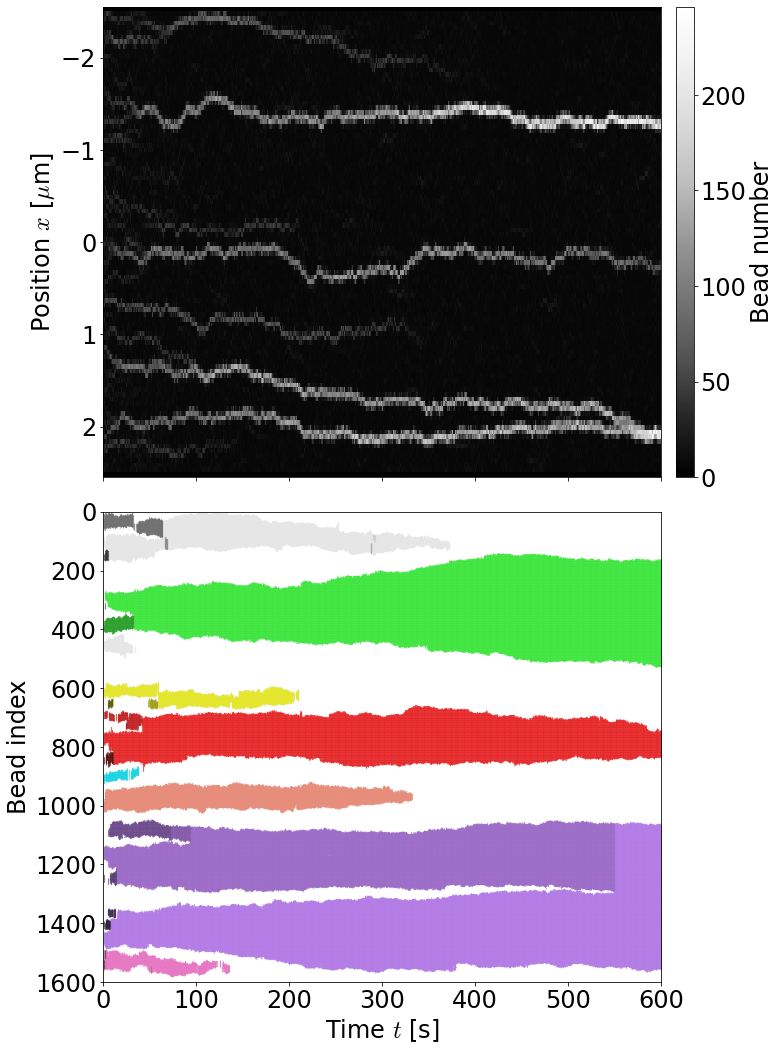

In [4]:
data_path = ceph_path / "DynCondPaper/23-10-20_aLc1_slice8.7._line1600_Pin1-13um_2xKe.1-300_ks100"
sim_path = data_path / "simulations/Ke100_Pin5.0um/"

tableau10_colors = iter(cycle(plt.cm.tab10.colors))

cluster_similarity_threshold = .4 
nskip = 10 # Time snapshot skips for cluster finding. = 10 secs
vmax = 40 # Max colorbar value in kymographs
tree_length = 30 # min length of a cluster tree in time snapshots. = 15 sec
part_min = 40

flat_time_arr = []
flat_clust_cent_arr = []
flat_clust_ind_arr = []

# Length of chain and time to look at
ss_ind = 1
end_ind = None
start_bead = 0
end_bead = None
with h5py.File(next(sim_path.glob('analysis/raw*.h5')), 'r') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    print(time_arr.shape)
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                        :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

    params = yaml.safe_load(h5_data.attrs['RunConfig'])

fig, axarr = plt.subplots(2,1, figsize=(10, 15), sharex=True)

# Collect data
h5_clust_file = sim_path / 'analysis/cluster_analysis.h5'
with h5py.File(h5_clust_file, 'r') as h5_data:
    cluster_grp = h5_data['clusters']
    time_arr = h5_data['time'][...]
    time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
    clusters = []
    for tg in time_grp_list:
        clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]

# Kymograph

# Project bead positions onto unit vector from first to last bead
proj_vec = com_arr[-1, :, 0] - com_arr[0, :, 0]
sep_dist = np.linalg.norm(proj_vec)
proj_vec /= sep_dist
proj_arr = np.einsum('ijk,j->ik', com_arr, proj_vec)
# Set range of histograms
range_min = -.51 * sep_dist
range_max = .51 * sep_dist
# Make a series of histograms for each time point
hist_arr = []

for i, proj in enumerate(proj_arr.T):
    hist, bin_edges = np.histogram(proj, bins=100,
                                range=(range_min, range_max))
    hist_arr += [hist]

hist_arr = np.asarray(hist_arr).T
max_color_bar = np.max(hist_arr)
x = np.append(time_arr, [time_arr[-1] + time_arr[2] - time_arr[1]])
X, Y = np.meshgrid(x, bin_edges)

c0 = axarr[0].pcolorfast(X, Y, hist_arr, cmap='Greys_r')

_ = axarr[0].set_ylabel(r"Position $x$ [$\mu$m]")

_ = axarr[0].invert_yaxis()


# Cluster tree
root_clusters = cla.find_descendants(clusters, thresh=cluster_similarity_threshold, nskip=nskip)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree]

for tree, color in zip(trees, tableau10_colors):
    if len(tree.clusters) < tree_length:
        continue
    branch_roots = tree.get_branch_roots()
    base_color_hsv = mcolors.rgb_to_hsv(color)
    base_color_hsv[2] = .9  
    color_step = .8 / len(branch_roots)
    
    for i, root in enumerate(branch_roots):
        branch_clusters = root.get_largest_branch()
        color_hsv = base_color_hsv.copy()
        color_hsv[2] = base_color_hsv[2] - (color_step*i) 
        branch_color = mcolors.hsv_to_rgb(color_hsv)

        for clust in branch_clusters:
            _ = axarr[1].plot([clust.time]*len(clust.part_ids), clust.part_ids, color = branch_color, markersize= .2, marker='.', linestyle='None')

_ = axarr[1].set_ylim(0, 1600)
_ = axarr[1].invert_yaxis()
_ = axarr[1].set_xlim(0, time_arr[-1])
_ = axarr[1].set_ylabel("Bead index")
_ = axarr[1].set_xlabel("Time $t$ [s]")



fig.tight_layout()
plot1_pos = axarr[0].get_position()
cb_pos = [plot1_pos.x0+plot1_pos.width + .02, plot1_pos.y0, .025, plot1_pos.height]
cax1 = fig.add_axes(cb_pos)

cb2 = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=max_color_bar), cmap='Greys_r'), 
                   cax = cax1, pad=0.1, label='Bead number' )

fig.savefig( 'Figure3/kymograph_tracking.png', dpi=600, bbox_inches='tight')



# Figure 3b

## Functions

In [33]:
def get_cluster_trees_from_h5file(h5_file, cluster_similarity_threshold = .4, nskip = 10, part_min = 0):
    clusters = []
    with h5py.File(h5_file, 'r') as h5_data:
        cluster_grp = h5_data['clusters']
        time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
        for tg in time_grp_list:
            clust_grp = [cla.Cluster(h5_data = c) for c in tg.values()]
            clust_grp = [clust for clust in clust_grp if len(clust.part_ids) > part_min]
            clusters += [clust_grp]

    root_clusters = cla.find_descendants(clusters, thresh=cluster_similarity_threshold, nskip=nskip)

    trees = []
    tree_id_gen = aa.helpers.gen_id()
    for root in root_clusters:
        tree = cla.ClusterTree(next(tree_id_gen))
        tree.add_recursive(root)
        trees += [tree]

    return trees

def get_lifetimes(branch_roots, min_time = 0, min_length = 0):
    lifetime_list = []
    for root in branch_roots:
        if root.time < min_time: # Skip if the root is too short
            continue
        l_branch = root.get_largest_branch()
        if len(l_branch) < min_length:
            continue
        lifetime_list += [l_branch[0].time-l_branch[-1].time]

    return lifetime_list

def plot_branches(axarr, full_time_arr, branch_roots, window_size=10, color = 'tab:blue'):
    time_list = []
    base_color_hsv = mcolors.rgb_to_hsv(color)
    base_color_hsv[2] = .9  
    color_step = .8 / len(branch_roots)

    for i, root in enumerate(branch_roots):

        color_hsv = base_color_hsv.copy()
        color_hsv[2] = base_color_hsv[2] - (color_step*i) 
        branch_color = mcolors.hsv_to_rgb(color_hsv)

        l_branch = root.get_largest_branch()
        size_arr = np.zeros(len(l_branch))
        time_arr = np.zeros(len(l_branch))
        for j, clust in enumerate(l_branch):
            size_arr[j] = len(clust.part_ids)
            time_arr[j] = clust.time

        size_arr_smooth = uniform_filter1d(size_arr, size=window_size)
        _ = axarr.plot(time_arr, size_arr_smooth, linestyle='-', linewidth=2, color=branch_color)
        if i > 0:
            _ = axarr.scatter(time_arr[0], size_arr_smooth[0],  marker='o', linewidth=2, s=100, facecolor="none", edgecolor=branch_color)

        if root.time == full_time_arr[-1]: 
            print('Skipping root')
            # Skip, this is not a real event
            continue
        time_list += [time_arr[0]-time_arr[-1]]
    return time_list

## Plots

Skipping root
Skipping root
Skipping root


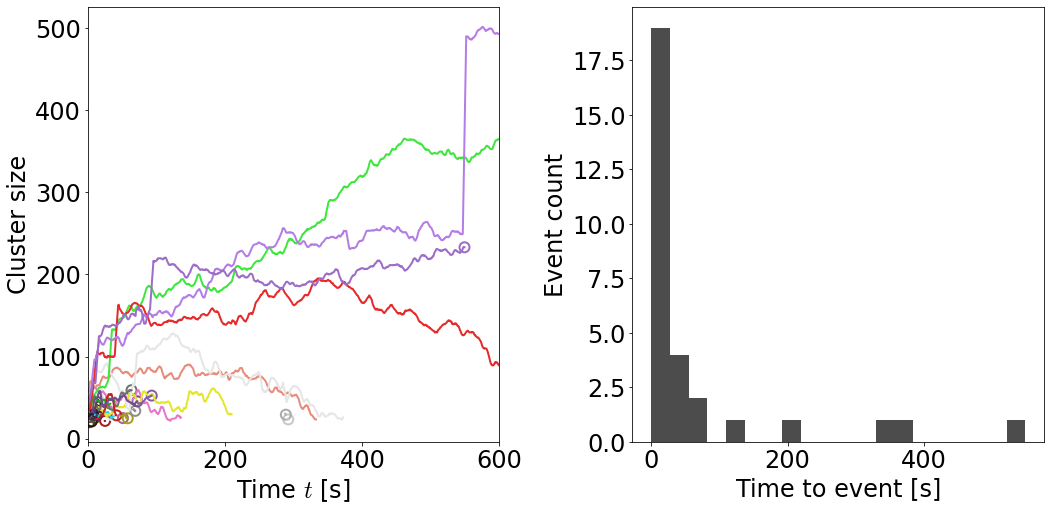

In [36]:
cluster_similarity_threshold = .4 
nskip = 10 # Time snapshot skips for cluster finding. = 10 secs
vmax = 40 # Max colorbar value in kymographs
tree_length = 30 # min length of a cluster tree in time snapshots. = 15 sec
part_min = 40
# tableau10_colors = iter(cycle(plt.cm.tab10.colors))


data_path = ceph_path / "DynCondPaper/23-10-20_aLc1_slice8.7._line1600_Pin1-13um_2xKe.1-300_ks100"
sim_path = data_path / "simulations/Ke100_Pin5.0um/"

h5_clust_file = sim_path / 'analysis/cluster_analysis.h5'
with h5py.File(h5_clust_file, 'r') as h5_data:
    cluster_grp = h5_data['clusters']
    time_arr = h5_data['time'][...]
    time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
    clusters = []

    for tg in time_grp_list:
        clust_grp = [cla.Cluster(h5_data = c) for c in tg.values()]
        # clust_grp = [clust for clust in clust_grp if len(clust.part_ids) > part_min]
        clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]

# Cluster tree
root_clusters = cla.find_descendants(clusters, thresh=cluster_similarity_threshold, nskip=nskip)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree]

fig, axarr = plt.subplots(1,2, figsize=(15, 7.5))
from scipy.ndimage.filters import uniform_filter1d

tableau10_colors = iter(cycle(plt.cm.tab10.colors))

merge_events = 0
time_list = []
for tree, color in zip(trees, tableau10_colors):
    if len(tree.clusters) < tree_length:
        continue
    branch_roots = tree.get_branch_roots()
    base_color_hsv = mcolors.rgb_to_hsv(color)
    base_color_hsv[2] = .9  
    color_step = .8 / len(branch_roots)

    tree.update_branch_roots()
    branch_roots = tree.get_branch_roots()
    merge_events += len(branch_roots)
    time_list += plot_branches(axarr[0], time_arr, branch_roots, color=color)

_ = axarr[0].set_xlabel('Time $t$ [s]')
_ = axarr[0].set_ylabel('Cluster size')
# _ = axarr[0].set_xscale('log')
# _ = axarr[0].set_xlim(0.5, 600)
_ = axarr[0].set_xlim(0, 600)

_ = axarr[1].hist(time_list, bins=20, color='black', alpha=.7)
_ = axarr[1].set_ylabel('Event count')
_ = axarr[1].set_xlabel('Time to event [s]')
fig.tight_layout()
fig.savefig('Figure3/branch_size.png', dpi=600, bbox_inches='tight')

In [37]:
# Total events
end_time = 600
min_time = 0
min_length = 5

data_path = ceph_path / "DynCondPaper/24-03-08_aLc1_slice5.5.13_line1600_Pin3-11um_2xKe3-300_ks100/"
sim_path = data_path / "simulations/Ke100_Pin5.0um/"

merge_lifetime_total_list = []
dissolve_lifetime_total_list = []
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)
for sd in sim_path.glob('s*'):
    trees = get_cluster_trees_from_h5file(sd / 'analysis/cluster_analysis.h5')
    for tree in trees:
        if len(tree.clusters) < 2*min_length:
            continue
        if tree.clusters[0].time < end_time > min_time:
            mb = tree.get_main_clust_branch()
            dissolve_lifetime_total_list += [mb[0].time-mb[-1].time]
        branch_roots = tree.get_branch_roots()
        merge_lifetime_total_list += get_lifetimes(branch_roots[1:], min_time=min_time, min_length=min_length)

min_time = 100
merge_lifetime_later_list = []
dissolve_lifetime_later_list = []
for sd in sim_path.glob('s*'):
    trees = get_cluster_trees_from_h5file(sd / 'analysis/cluster_analysis.h5')
    for tree in trees:
        if len(tree.clusters) < 2*min_length:
            continue
        if tree.clusters[0].time < end_time and tree.clusters[0].time > min_time:
            mb = tree.get_main_clust_branch()
            dissolve_lifetime_later_list += [mb[0].time-mb[-1].time]
        branch_roots = tree.get_branch_roots()
        merge_lifetime_later_list += get_lifetimes(branch_roots[1:], min_time=min_time, min_length=min_length)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


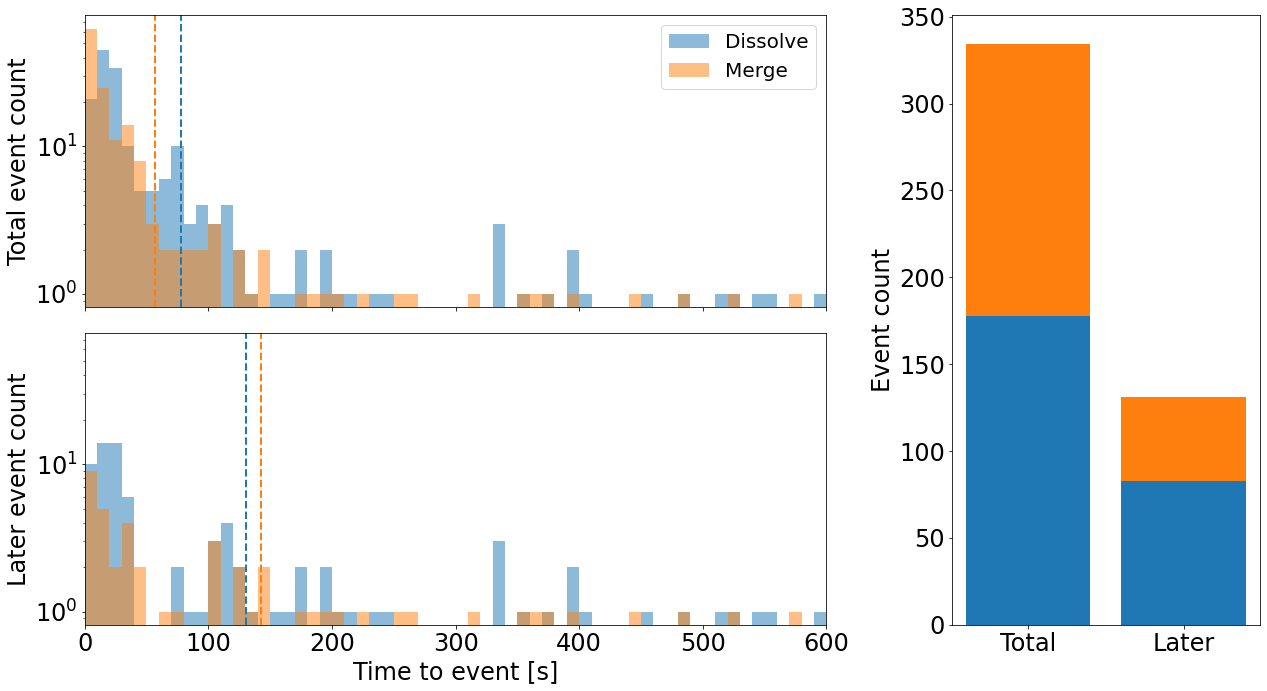

In [38]:

gs = gridspec.GridSpec(2, 3)

fig = plt.figure(figsize=(18, 10))
axarr = [fig.add_subplot(gs[0, 0:2])]

fig.subplots_adjust(hspace=0.1, wspace=0.7)
axarr += [fig.add_subplot(gs[1, :2], sharex=axarr[0], sharey=axarr[0]), fig.add_subplot(gs[:, 2:])]

_ = axarr[0].hist(dissolve_lifetime_total_list, bins=60, label='Dissolve', alpha=.5, range=(0, 600))
_ = axarr[0].hist(merge_lifetime_total_list, bins=60, label='Merge', alpha=.5, range=(0, 600))
_ = axarr[0].axvline(np.mean(dissolve_lifetime_total_list), color='C0', linestyle='--')
_ = axarr[0].axvline(np.mean(merge_lifetime_total_list), color='C1', linestyle='--')
_ = axarr[0].legend()
_ = axarr[0].set_yscale('log')  
_ = axarr[0].set_ylabel('Total event count')
_ = axarr[0].set_xlim(0, 600)


_ = axarr[1].set_ylabel('Later event count')
_ = axarr[1].hist(dissolve_lifetime_later_list, bins=60, label='Dissolve', alpha=.5, range=(0, 600))
_ = axarr[1].hist(merge_lifetime_later_list, bins=60, label='Merge', alpha=.5, range=(0, 600))
_ = axarr[1].axvline(np.mean(dissolve_lifetime_later_list), color='C0', linestyle='--')
_ = axarr[1].axvline(np.mean(merge_lifetime_later_list), color='C1', linestyle='--')
_ = axarr[1].set_xlabel('Time to event [s]')

_ = axarr[2].bar(['Total', 'Later'], [np.size(dissolve_lifetime_total_list), np.size(dissolve_lifetime_later_list)], color=['tab:blue', 'tab:blue'])
_ = axarr[2].bar(['Total', 'Later'], [np.size(merge_lifetime_total_list), np.size(merge_lifetime_later_list)], bottom=[np.size(dissolve_lifetime_total_list), np.size(dissolve_lifetime_later_list)], color=['tab:orange', 'tab:orange'])
_ = axarr[2].set_ylabel('Event count')

_ = plt.setp(axarr[0].get_xticklabels(), visible=False)
# axarr[0].label_outer()
fig.tight_layout()

fig.savefig('Figure3/lifetime_histograms.png', dpi=600, bbox_inches='tight')
            

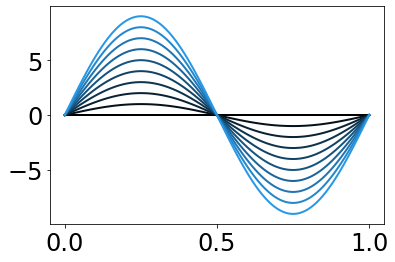

In [21]:
import matplotlib.colors as mcolors

x = np.linspace(0, 1, 100)
y = np.sin(2 * np.pi * x)

# Define the original color (in RGB format)
tableau10_colors = iter(cycle(plt.cm.tab10.colors))
base_color_hsv = mcolors.rgb_to_hsv(next(tableau10_colors))
base_color_hsv[2] = .00001  

for i in range(0,10):
    # Convert the RGB color to HSV
    # Change the hue (the first element of the HSV array)
    color_hsv = base_color_hsv.copy()
    color_hsv[2] = base_color_hsv[2] + (0.1*i)  # Add 0.1 to the hue
    # Make sure the hue is between 0 and 1
    color_hsv[2] %= 1
    # Convert the HSV color back to RGB
    new_color_rgb = mcolors.hsv_to_rgb(color_hsv)
    _ = plt.plot(x, i*y, label='sin(x)', color=new_color_rgb)

# Supplement

In [ ]:
data_path = ceph_path / "DynCondPaper/23-10-20_aLc1_slice8.7._line1600_Pin1-13um_2xKe.1-300_ks100"
sim_path = data_path / "simulations/Ke100_Pin5.0um/"

tableau10_colors = iter(cycle(plt.cm.tab10.colors))

cluster_similarity_threshold = .4 
nskip = 10 # Time snapshot skips for cluster finding. = 10 secs
vmax = 40 # Max colorbar value in kymographs
tree_length = 30 # min length of a cluster tree in time snapshots. = 15 sec
part_min = 40

flat_time_arr = []
flat_clust_cent_arr = []
flat_clust_ind_arr = []

# Length of chain and time to look at
ss_ind = 1
end_ind = None
start_bead = 0
end_bead = None
with h5py.File(next(sim_path.glob('analysis/raw*.h5')), 'r') as h5_data:
    time_arr = h5_data['time'][ss_ind:end_ind]
    print(time_arr.shape)
    sy_dat = h5_data['raw_data/sylinders'][start_bead:end_bead,
                                        :, ss_ind:end_ind]
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])

fig, axarr = plt.subplots(2,2, figsize=(20, 15), sharex=True)

# Kymograph
h5_contact_file = sim_path / 'analysis/contact_analysis.h5'
with h5py.File(h5_contact_file, 'r') as h5_data:
    time_arr = h5_data['time'][...]
    contact_kymo = h5_data['contact_kymo'][...]

    plot_contact_kymo(fig, axarr[0,0], time_arr, contact_kymo, vmax=vmax)
    _ = axarr[0,0].set_ylim(0, 1600)
    _ = axarr[0,0].invert_yaxis()


h5_clust_file = sim_path / 'analysis/cluster_analysis.h5'
with h5py.File(h5_clust_file, 'r') as h5_data:
    cluster_grp = h5_data['clusters']
    time_arr = h5_data['time'][...]
    time_grp_list = sorted(cluster_grp.values(), key=lambda x: x.attrs['time'])
    clusters = []
    for tg in time_grp_list:
        clusters += [[cla.Cluster(h5_data = c) for c in tg.values()]]

# Cluster position
bead_ind_arr = np.zeros((com_arr.shape[0], com_arr.shape[2]))
one_mask = np.ones(com_arr.shape[0])
for c, clust_grp in enumerate(clusters):
    # Secondary thresholding
    clust_grp = [clust for clust in clust_grp if len(clust.part_ids) > part_min]
    num_beads = 0
    for i, clust in enumerate(clust_grp):
        flat_time_arr += [clust.time]
        flat_clust_cent_arr += [clust.center]
        flat_clust_ind_arr += [clust.part_ids]
        bead_ind_arr[clust.part_ids,c] += one_mask[clust.part_ids]

flat_clust_cent_arr = np.asarray(flat_clust_cent_arr)
_ = axarr[0,1].invert_yaxis()
_ = axarr[0,1].plot(flat_time_arr, flat_clust_cent_arr[:,0], '.' )
_ = axarr[0,1].set_ylabel(r'$x$-position [$\mu {\rm m}$]')

# Cluster tree
root_clusters = cla.find_descendants(clusters, thresh=cluster_similarity_threshold, nskip=nskip)

trees = []
tree_id_gen = aa.helpers.gen_id()
for root in root_clusters:
    tree = cla.ClusterTree(next(tree_id_gen))
    tree.add_recursive(root)
    trees += [tree]


# Graph all clusters
for tree, color in zip(trees, tableau10_colors):
    if len(tree.clusters) < tree_length:
        continue
    for clust in tree.clusters:
        _ = axarr[1,0].plot([clust.time]*len(clust.part_ids), clust.part_ids, color = color, markersize= .1, marker='.', linestyle='None')

# Graph largest branch
biggest_tree = max(trees, key=lambda x: x.get_main_clust_branch()[0].mass_hist)
biggest_tree.update_branch_roots()
branch_roots = biggest_tree.get_branch_roots()

for root, color in zip(branch_roots, tableau10_colors):
    branch_clusters = root.get_largest_branch()
    for clust in branch_clusters:
        _ = axarr[1,1].plot([clust.time]*len(clust.part_ids), clust.part_ids, color = color, markersize= .1, marker='.', linestyle='None')

_ = axarr[1,0].set_ylabel("Bead index")
_ = axarr[1,1].set_yticklabels([])
for ax in axarr[1,:]:
    _ = ax.set_ylim(0, 1600)
    _ = ax.invert_yaxis()
    _ = ax.set_xlim(0, time_arr[-1])
    _ = ax.set_xlabel("Time $t$ [s]")


fig.tight_layout()

